In [2]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import time

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from data_manager import *
from metadata import *

import matplotlib.pyplot as plt
%matplotlib inline

from multiprocess import Pool

from learning_utilities import *

Setting environment for Gordon


No vtk
Cannot import mxnet.


In [3]:
from skimage.filters import gaussian

In [4]:
stack = 'MD589'
s2f = metadata_cache['sections_to_filenames'][stack]
first_sec, last_sec = metadata_cache['section_limits'][stack]
im_w, im_h = metadata_cache['image_shape'][stack]

In [5]:
paired_structures = ['5N', '6N', '7N', '7n', 'Amb', 'LC', 'LRt', 'Pn', 'Tz', 'VLL', 'RMC', 'SNC', 'SNR', '3N', '4N',
                    'Sp5I', 'Sp5O', 'Sp5C', 'PBG', '10N', 'VCA', 'VCP', 'DC']
singular_structures = ['AP', '12N', 'RtTg', 'SC', 'IC']
structures = paired_structures + singular_structures

In [6]:
feature_vec = np.dstack(DataManager.load_scoremap(stack=stack, section=200, downscale_factor=8,
                                        label=s, train_sample_scheme=1) for s in structures).astype(np.float16)

In [7]:
img = imread(DataManager.get_image_filepath(stack=stack, section=200))[::8, ::8]

/oasis/projects/nsf/csd395/yuncong/brain_virtualenv/lib/python2.7/site-packages/PIL/Image.py:2274: DecompressionBombWarning: Image size (185246720 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


In [8]:
img_smoothed = img_as_ubyte(gaussian(img[..., 1], sigma=3))

/oasis/projects/nsf/csd395/yuncong/brain_virtualenv/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [9]:
mask = DataManager.load_thumbnail_mask_v2(stack=stack, section=200)

In [10]:
r = 30

In [11]:
feature_pool = []
grayval_pool = []
locations = []
for y in range(100, img.shape[0]-100, 50):
    for x in range(100, img.shape[1]-100, 50):
        if mask[y/8, x/8]:
#             grayval_pool.append(np.uint8(np.mean(img[y-r:y+r, x-r:x+r])))
            grayval_pool.append(img_smoothed[y, x])
            feature_pool.append(feature_vec[y, x])
            locations.append((x,y))

In [ ]:
n = len(feature_pool)

# Find pairs

In [78]:
D_feat = pdist(feature_pool)
D_grey = pdist([[v] for v in grayval_pool])

In [81]:
# Method 1

# n_pair = D_feat.size
# rank_feat = dict(zip(np.argsort(D_feat)[::-1], range(n_pair)))
# rank_grey = dict(zip(np.argsort(D_grey), range(n_pair)))
# rank = [rank_feat[i] + rank_grey[i] for i in range(n_pair)]
# best_pair_indices = np.argsort(rank)

# Method 2

pair_indices_same_gray = np.where(D_grey == 0)[0]
best_pair_indices = pair_indices_same_gray[np.argsort(D_feat[pair_indices_same_gray])[::-1]]

In [82]:
rs, cs = np.triu_indices(n, k=1)

In [ ]:
k = 5
fig, axes = plt.subplots(nrows=k, ncols=6, figsize=(6*3, k*3), squeeze=True)

for i in range(k):

    best_pair_index = best_pair_indices[i]
    ind1, ind2 = rs[best_pair_index], cs[best_pair_index]
    x1, y1 = locations[ind1]
    x2, y2 = locations[ind2]
    
    axes[i,0].imshow(img_smoothed[y1-r:y1+r, x1-r:x1+r], cmap=plt.cm.gray, vmin=0, vmax=255);
    axes[i,0].axis('off');
    axes[i,0].set_title('Patch %d@(%d,%d)' % (ind1, x1, y1));

    axes[i,1].imshow(img_smoothed[y2-r:y2+r, x2-r:x2+r], cmap=plt.cm.gray, vmin=0, vmax=255);
    axes[i,1].axis('off');
    axes[i,1].set_title('Patch %d@(%d,%d)' % (ind2, x2, y2));

    axes[i,2].imshow(img[y1-r:y1+r, x1-r:x1+r]);
    axes[i,2].axis('off');
    axes[i,2].set_title('Patch %d@(%d,%d)' % (ind1, x1, y1));
    
    axes[i,3].imshow(img[y2-r:y2+r, x2-r:x2+r]);
    axes[i,3].axis('off');
    axes[i,3].set_title('Patch %d@(%d,%d)' % (ind2, x2, y2));
    
    most_diff_feat = np.argsort(np.abs(feature_pool[ind1] - feature_pool[ind2]))[-1]
    
    axes[i,4].imshow(feature_vec[y1-r:y1+r, x1-r:x1+r, most_diff_feat]);
    axes[i,4].axis('off');
    axes[i,4].set_title('Patch %d@(%d,%d), %s' % (ind1, x1, y1, structures[most_diff_feat]));
    
    axes[i,5].imshow(feature_vec[y2-r:y2+r, x2-r:x2+r, most_diff_feat]);
    axes[i,5].axis('off');
    axes[i,5].set_title('Patch %d@(%d,%d), %s' % (ind2, x2, y2, structures[most_diff_feat]));

fig.show()

# Show a group

In [12]:
from itertools import groupby
grayval_grouped = {gg: [i for g, i in group] 
     for gg, group in groupby(sorted([(g, i) for i, g in enumerate(grayval_pool)]), lambda (g, i): g)}

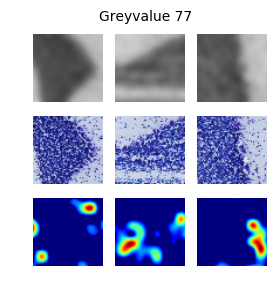

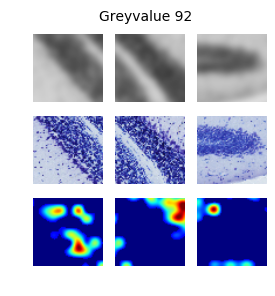

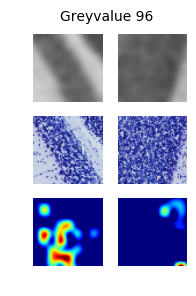

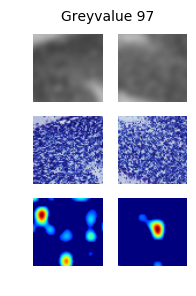

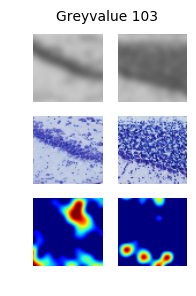

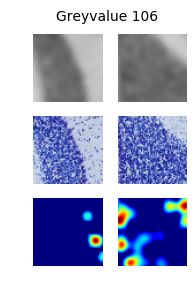

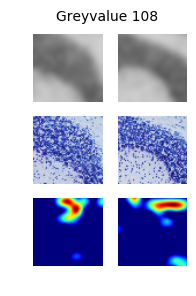

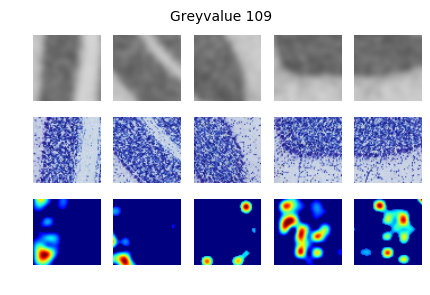

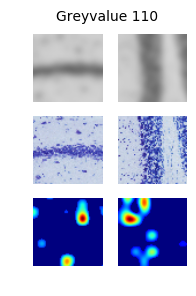

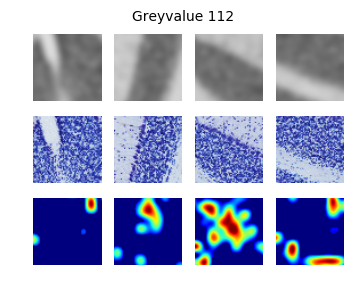

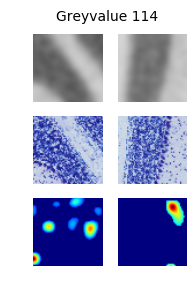

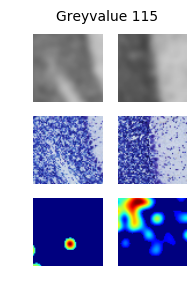

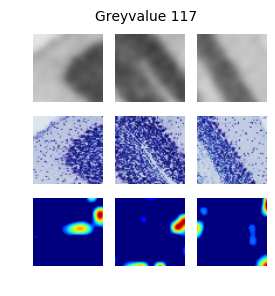

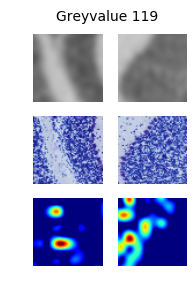

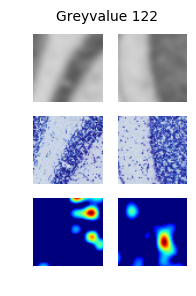

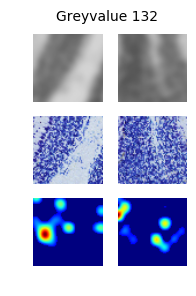

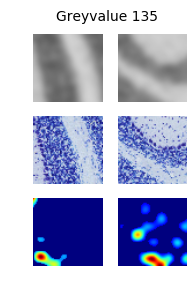

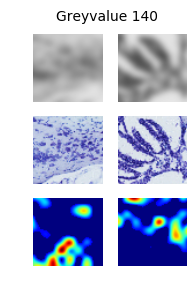

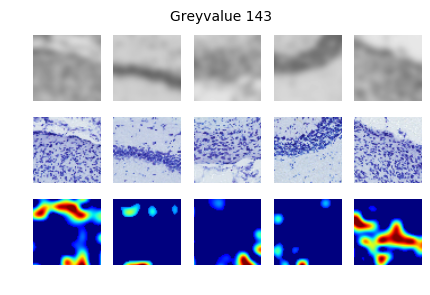

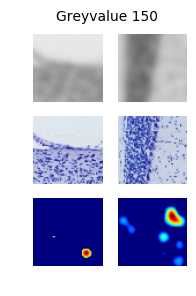

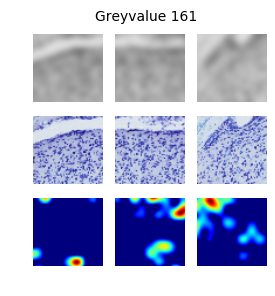

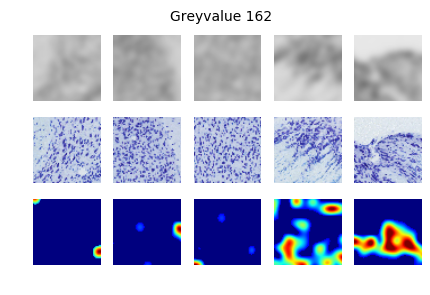

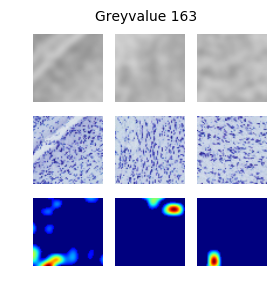

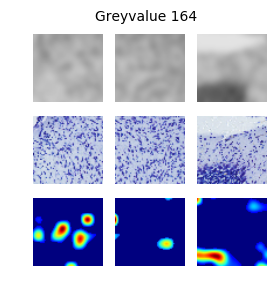

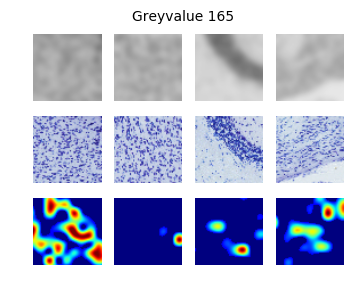

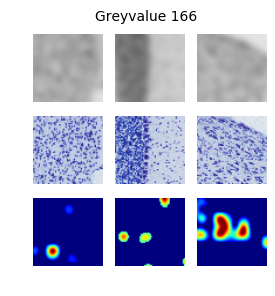

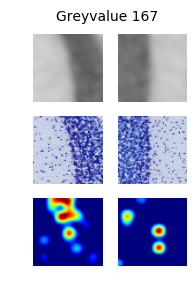

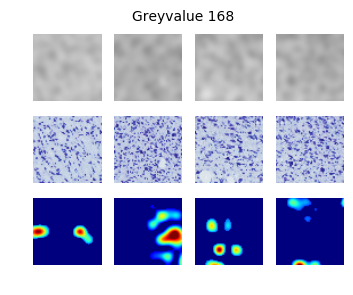

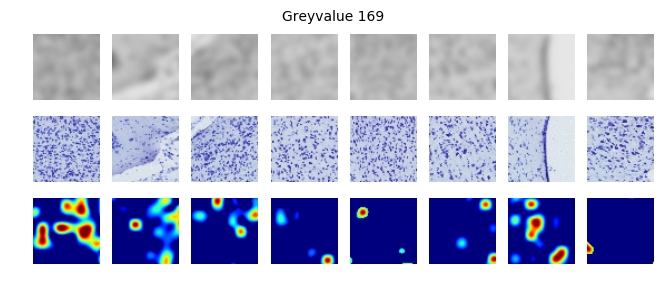

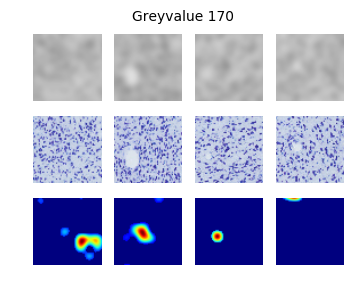

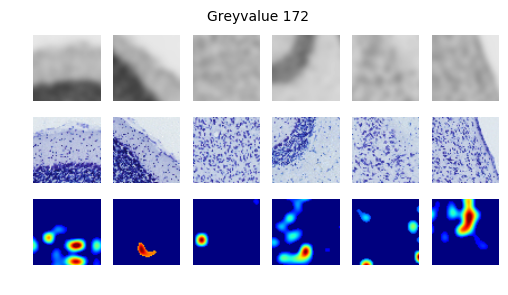

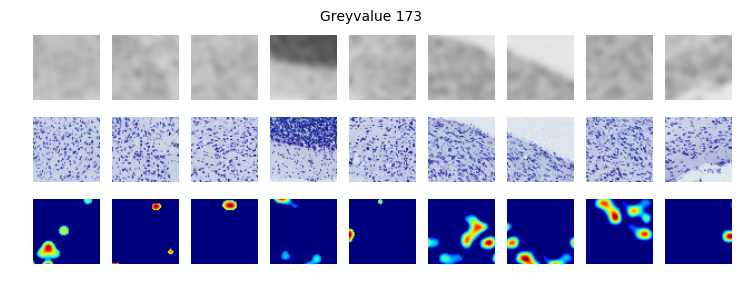

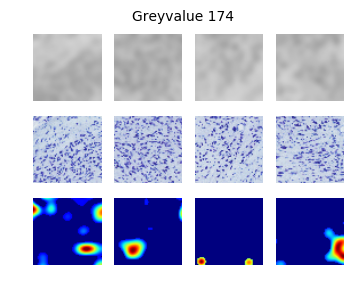

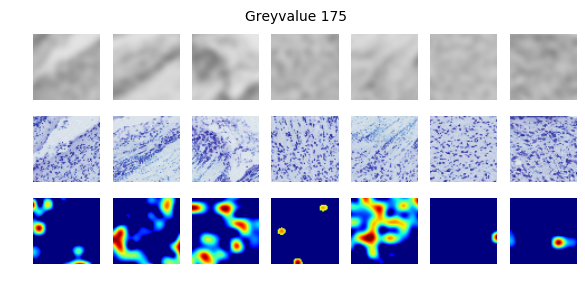

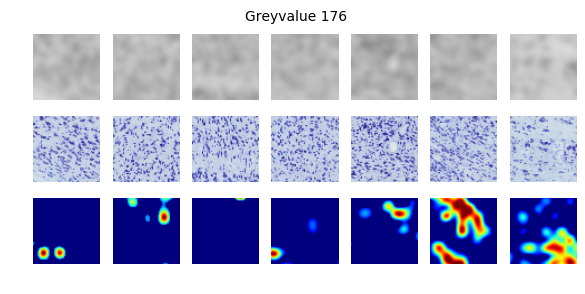

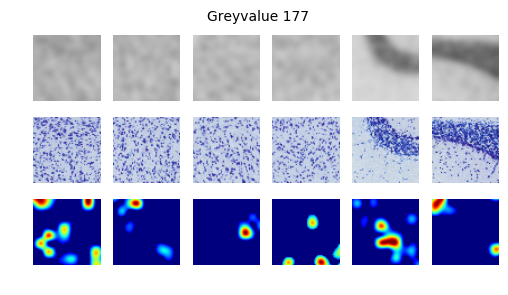

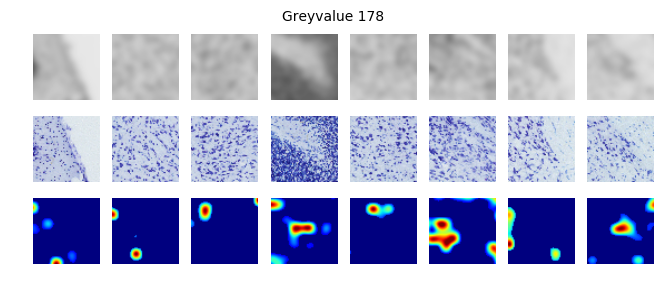

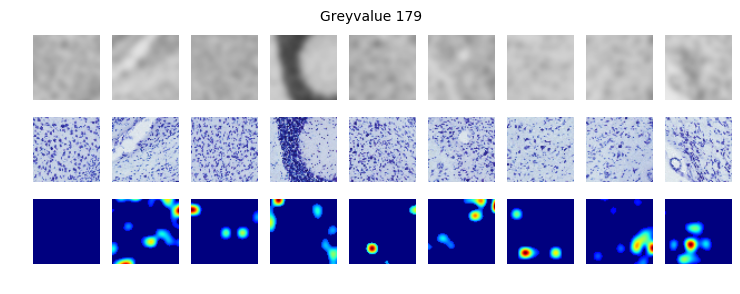

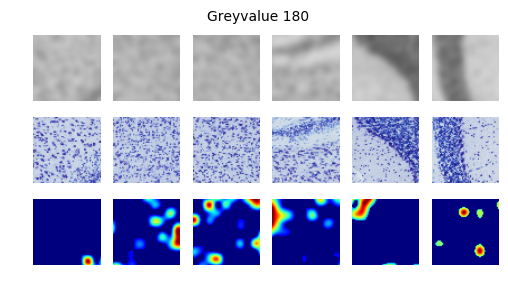

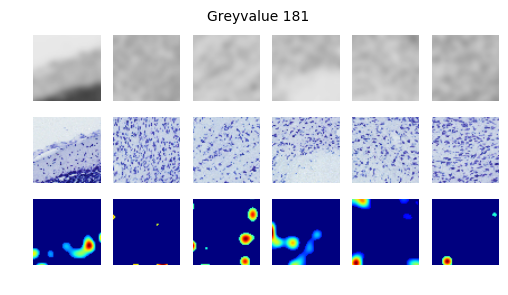

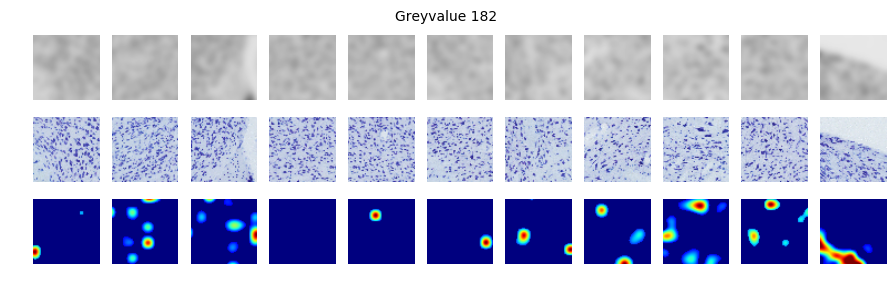

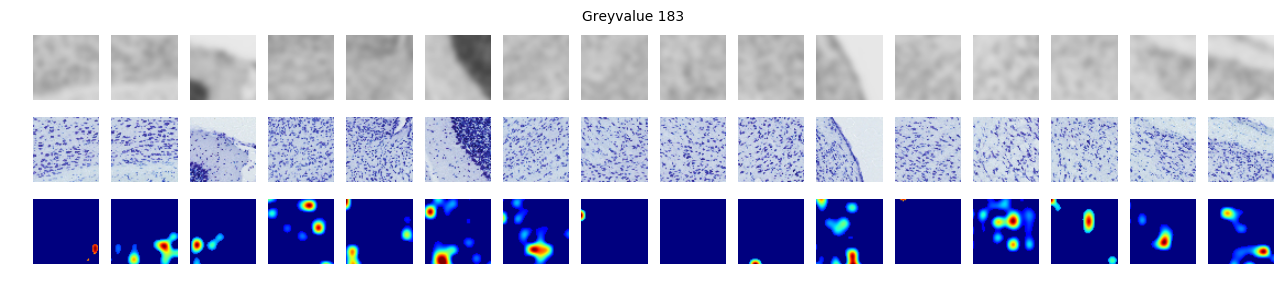

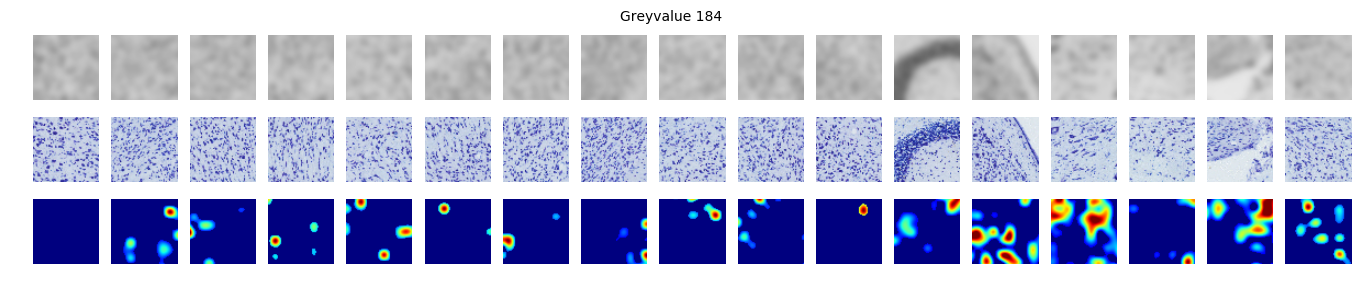

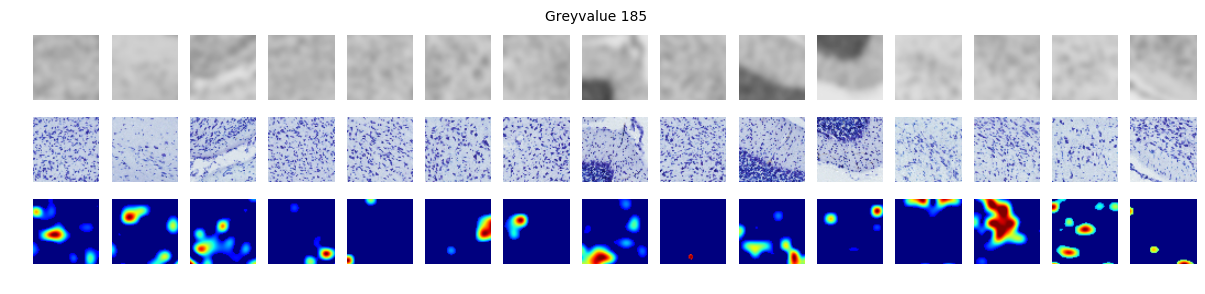

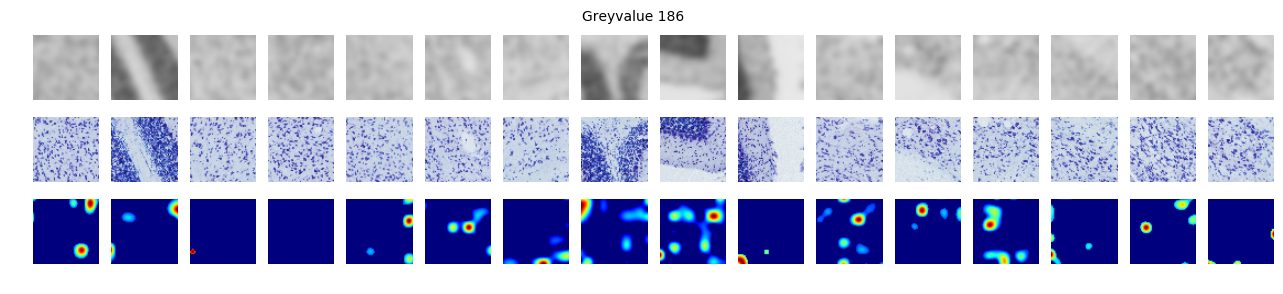

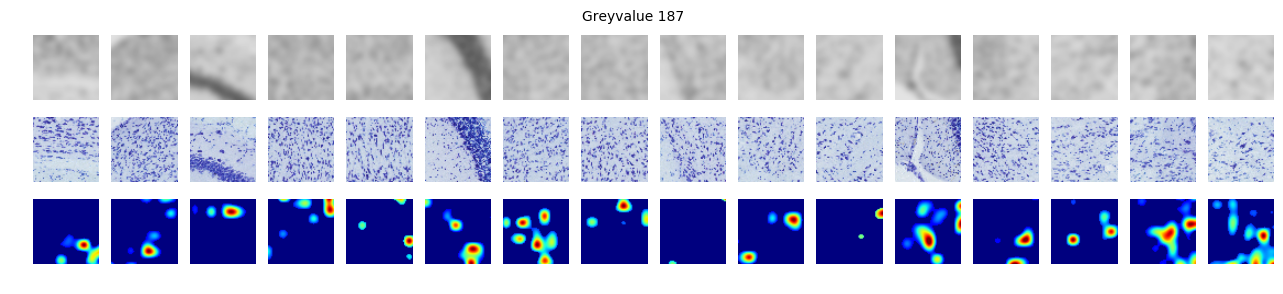

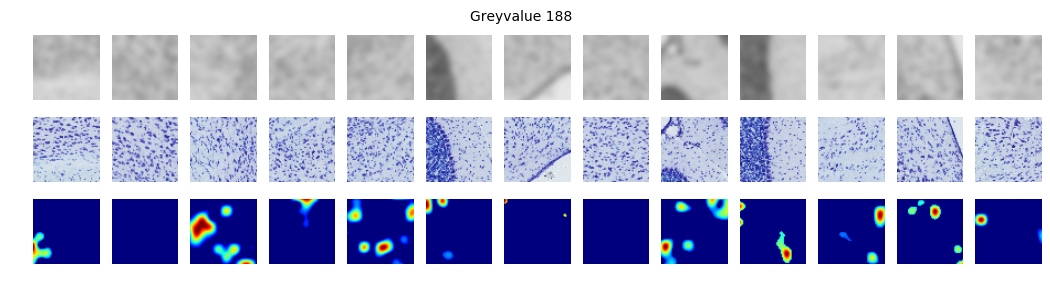

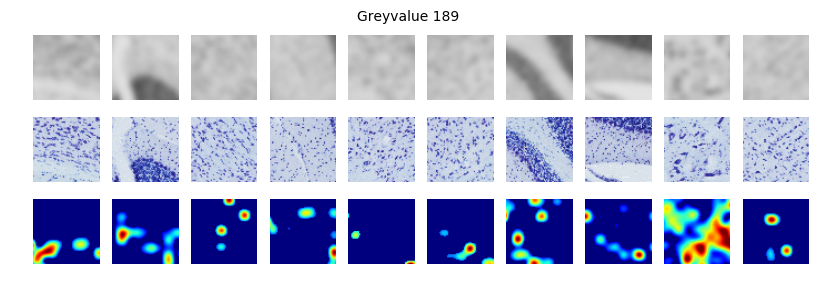

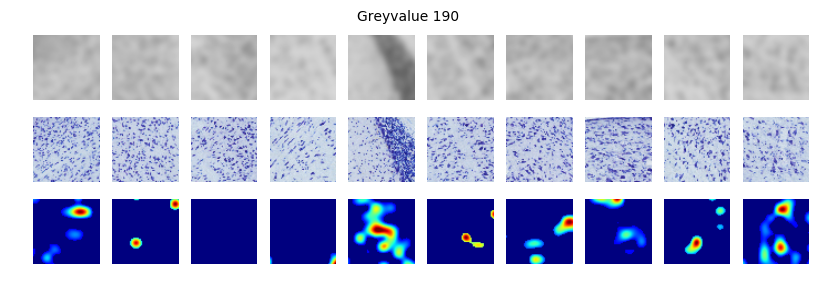

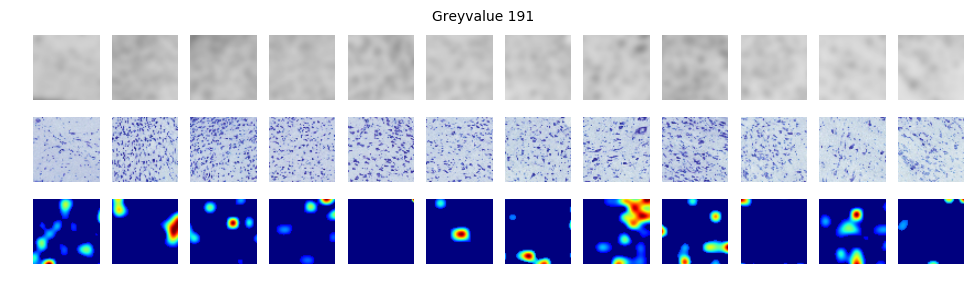

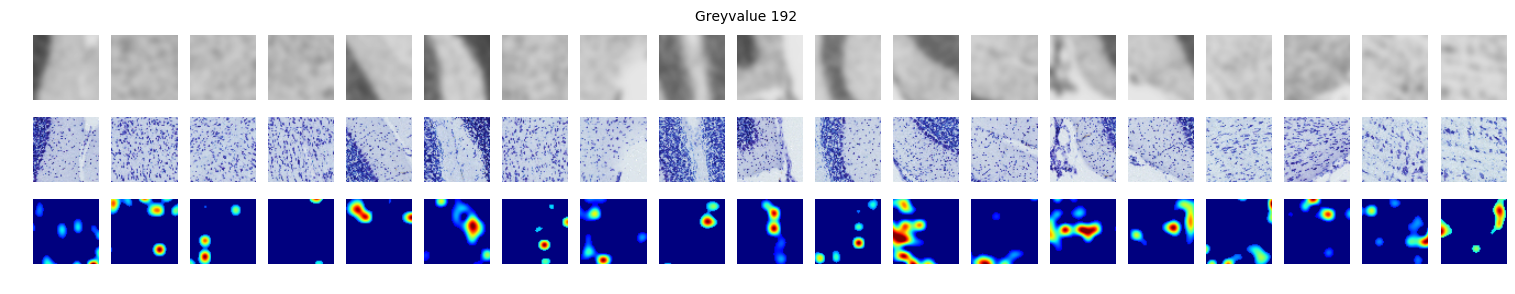

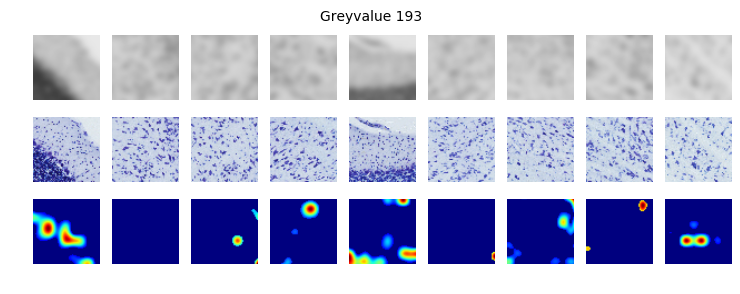

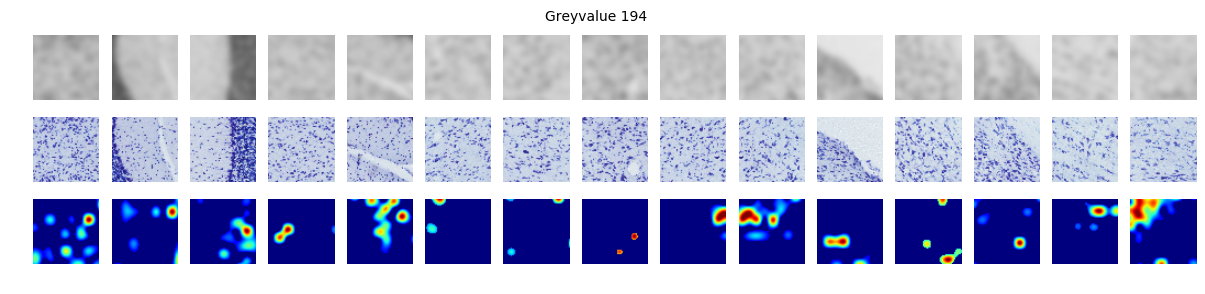

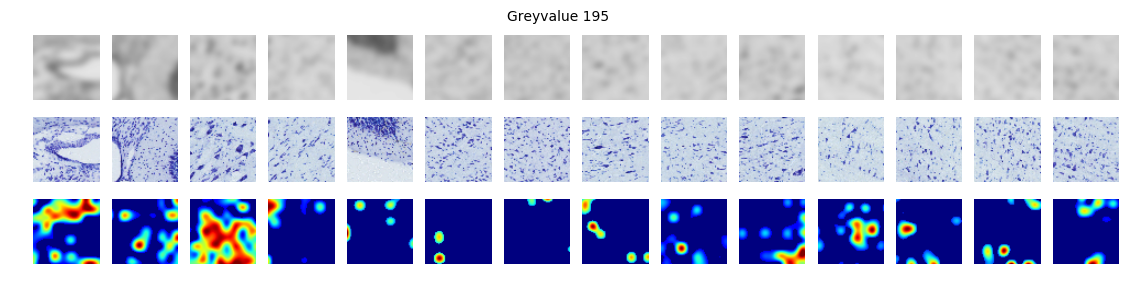

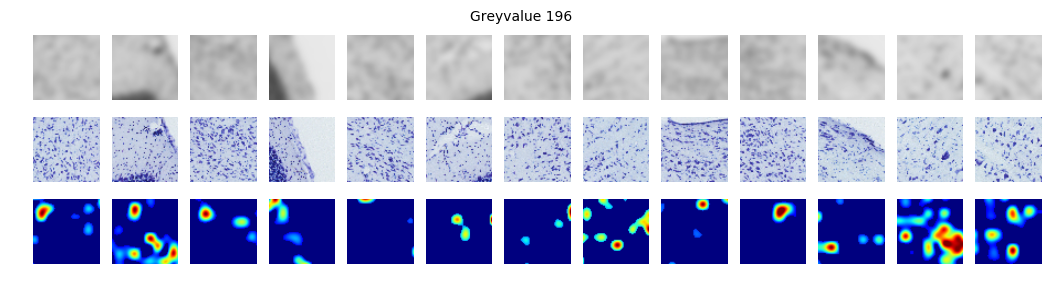

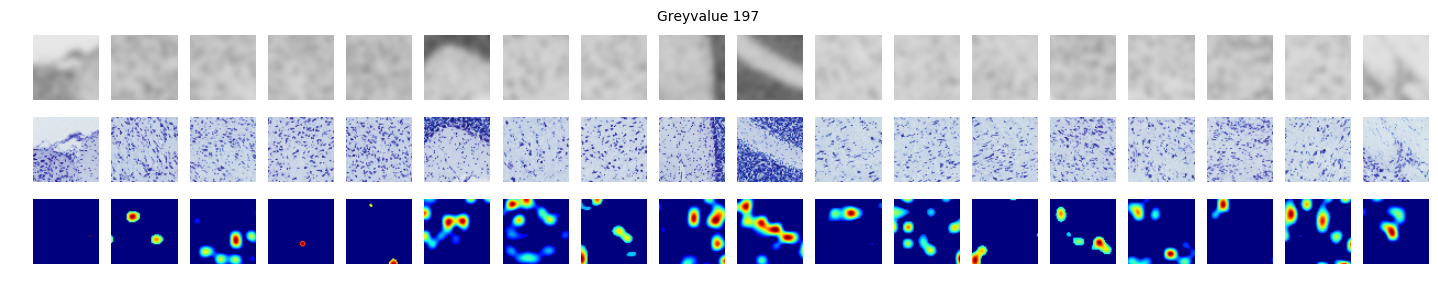

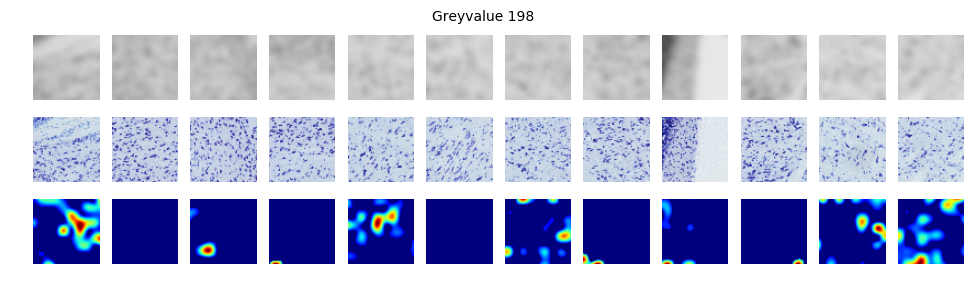

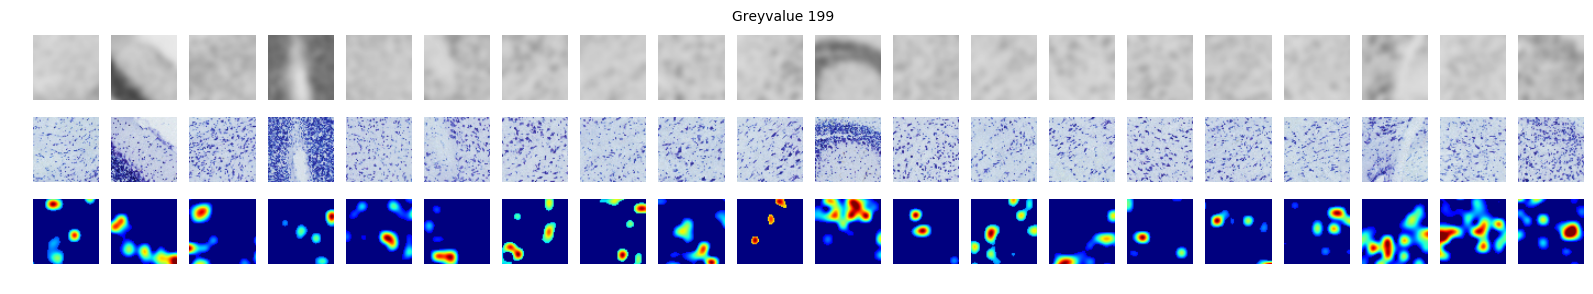

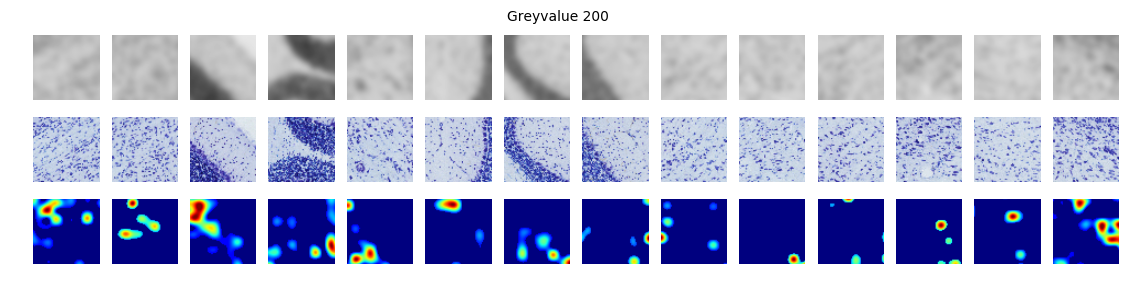

In [15]:
for g, indices in grayval_grouped.iteritems():
    
    if g > 200:
        continue
    
    nn = len(indices)
    if n == 1:
        continue
        
    fig, axes = plt.subplots(nrows=3, ncols=nn, figsize=(nn*1, 3*1), squeeze=False)
    
    for i, ind in enumerate(indices):
    
        x, y = locations[ind]

        axes[0,i].imshow(img_smoothed[y-r:y+r, x-r:x+r], cmap=plt.cm.gray, vmin=0, vmax=255);
        axes[0,i].axis('off');
#         axes[0,i].set_title('Patch %d@(%d,%d)' % (ind, x, y));

        axes[1,i].imshow(img[y-r:y+r, x-r:x+r]);
        axes[1,i].axis('off');
#         axes[1,i].set_title('Patch %d@(%d,%d)' % (ind, x, y));

    #     most_diff_feat = np.argsort(np.abs(feature_pool[ind1] - feature_pool[ind2]))[-1]
    
        most_diff_feat = 0

        axes[2,i].imshow(feature_vec[y-r:y+r, x-r:x+r, most_diff_feat]);
        axes[2,i].axis('off');
#         axes[2,i].set_title('Patch %d@(%d,%d), %s' % (ind, x, y, structures[most_diff_feat]));

    fig.suptitle('Greyvalue %d' % g)
    fig.show()

In [ ]:
# for g, indices in grayval_grouped.iteritems():
    
#     if g > 200:
#         continue
    
#     n = len(indices)
#     if n == 1:
#         continue
    
#     fig, axes = plt.subplots(nrows=n, ncols=3, figsize=(3*1, n*1), squeeze=False)
    
#     for i, ind in enumerate(indices):
    
#         x, y = locations[ind]

#         axes[i,0].imshow(img_smoothed[y-r:y+r, x-r:x+r], cmap=plt.cm.gray, vmin=0, vmax=255);
#         axes[i,0].axis('off');
# #         axes[0,i].set_title('Patch %d@(%d,%d)' % (ind, x, y));

#         axes[i,1].imshow(img[y-r:y+r, x-r:x+r]);
#         axes[i,1].axis('off');
# #         axes[1,i].set_title('Patch %d@(%d,%d)' % (ind, x, y));

#     #     most_diff_feat = np.argsort(np.abs(feature_pool[ind1] - feature_pool[ind2]))[-1]
    
#         most_diff_feat = 0

#         axes[i,2].imshow(feature_vec[y-r:y+r, x-r:x+r, most_diff_feat]);
#         axes[i,2].axis('off');
# #         axes[2,i].set_title('Patch %d@(%d,%d), %s' % (ind, x, y, structures[most_diff_feat]));

# #     plt.tight_layout()
#     fig.suptitle('Greyvalue %d' % g)
#     fig.show()